# SVM Classification for face recognition

In [1]:
import os
import glob
import math

import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from imageio import imread

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras import utils

from collections import Counter
import joblib

%matplotlib inline

## Configuration parameters

In [2]:
# Directory with images to be processed
image_dir_basepath = '../data/images-out-aligned/'

# Whether to persist the trained model for future inferences
persist_model = False

# Path where the pre-trained model is stored
model_path = '../model/keras/model/facenet_keras.h5'

names = [dir.split('/')[-1] for dir in glob.glob(os.path.join(image_dir_basepath, '*'))]
model = load_model(model_path)

## Functions

In [3]:
def prewhiten(image):
    """
    Subtracts the average and normalizes the range of the pixel
    values of input images. Makes training a lot easier.
    
    Reference: https://en.wikipedia.org/wiki/Standard_score
    """
    # ARGB: RGB + Alpha or Transparency channel (remove this channel)
    if image.ndim == 4:
        axis = (1, 2, 3)
        size = image[0].size
    # RGB
    elif image.ndim == 3:
        axis = (0, 1, 2)
        size = image.size
    else:
        raise ValueError('Dimension should be 3 or 4 an is: {}'.format(image.ndim))

    mean = np.mean(image, axis=axis, keepdims=True)
    std = np.std(image, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (image - mean) / std_adj

    return y

In [4]:
def load_images(filepaths):
    """
    param: filepaths: List of image paths
    
    Returns the matrix representation of each image as a NumPy Array
    """
    images = []

    for filepath in filepaths:
        img = imread(filepath)
        images.append(img)

    return np.array(images)

### Augmentation

The dataset is extended through augmentation using Keras ImageDataGenerator API. Augmented images are generated in batches of 32 elements. 

In [5]:
def augmentation(images, labels, num_iterations, seed=1):
    """
    param: images: List of matrix representation of images.
    param: labels: List of true labels.
    param: num_iterations: Number of times the augmented generation should run (batches of 32 elements)
                           num_iterations * 32 = number of augmented images.
    param: seed: Random seed.
    
    Returns a list of augmented images and its corresponding labels
    """
    aug_images = []
    aug_labels = []
    
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.5, 
        brightness_range=[0.3,0.8],
        horizontal_flip=True,
        fill_mode="nearest")

    aug_iter = datagen.flow(images, labels, seed=seed, batch_size=32)
    for i in range(num_iterations):
        x, y = next(aug_iter)
        aug_images.extend(x)
        aug_labels.extend(y)

    return aug_images, aug_labels

### Embeddings

An embedding is a spacial vector representation of a face. The embedding is generated using the pre-trained Facenet model.

In [6]:
def calc_embs(images, batch_size=1):
    """
    Returns a list of embeddings (representing each image as a vector)
    """
    pd = []
    for start in range(0, len(images), batch_size):
        m = model.predict_on_batch(images[start:start+batch_size])
        pd.append(m)

    # Apply L2 Normalization
    embs = utils.normalize(np.concatenate(pd), axis=-1, order=2)

    return embs

### Train

An embedding is calculated for each face, then an SVC model is trained using the embeddings and validated using k-fold cross validation. The minimum number of members in any class cannot be less than the paramater "cv".

In [7]:
def train(filepaths, labels, c=10, cv=10, num_aug_iterations=0):
    images = prewhiten(load_images(filepaths))
    print("Images to process: {}".format(len(images)))
    
    if num_aug_iterations > 0:
        aug_images, aug_labels = augmentation(images, labels, num_aug_iterations)
        images = np.concatenate((images, prewhiten(np.array(aug_images))), axis=0)
        labels = np.concatenate((labels, aug_labels), axis=0)
        print("Images after augmentation: {} (+{})".format(len(images), len(aug_images)))
    
    embs = calc_embs(images)
    
    lencoder = LabelEncoder().fit(labels)
    y = lencoder.transform(labels)

    clf = SVC(kernel='linear', C=c, probability=True, max_iter=-1)
    scores = cross_val_score(clf, embs, y, cv=cv)
    
    print('Scores: {}'.format(scores))
    # 95% of the data is within 2 standard deviations of the mean
    print('Train accuracy: {:0.2f} (+/- {:0.2f})'.format(scores.mean(), scores.std() * 2))

    clf.fit(embs, y)
    
    return lencoder, clf

### Inference

In [8]:
def infer(lencoder, clf, samples):
    images = prewhiten(load_images(samples))
    embs = calc_embs(images)
    predict_proba = clf.predict_proba(embs)
    pred = [p.argmax() for p in predict_proba]
    proba = [p[p.argmax()] for p in predict_proba]

    return (embs, lencoder.inverse_transform(pred), proba)

## Split dataset into training and test

In [9]:
test_size = 0.45
train_size = None
dataset_x = []
dataset_y = []

for name in names:
    dirpath = os.path.abspath(os.path.join(image_dir_basepath, name))
    image_paths = glob.glob(os.path.join(dirpath, '*.jpg'))
    dataset_x.extend(image_paths)
    dataset_y.extend([name] * len(image_paths))
    
print('Dataset size: {}'.format(len(dataset_x)))

x_train, x_test, y_train, y_test = train_test_split(dataset_x, dataset_y, random_state=0,
                                                    train_size=train_size, test_size=test_size,
                                                    stratify=dataset_y)

print('Train size: {}'.format(len(x_train)))
print('Test size: {}'.format(len(x_test)))

Dataset size: 96
Train size: 52
Test size: 44


## Train model

In [10]:
lencoder, clf = train(x_train, y_train, c=10, cv=3, num_aug_iterations=150)

Images to process: 52
Images after augmentation: 3952 (+3900)
Scores: [1. 1. 1.]
Train accuracy: 1.00 (+/- 0.00)


## Test model

In [11]:
embs, pred, proba = infer(lencoder, clf, x_test)

In [12]:
y_pred = lencoder.transform(pred)
y_true = lencoder.transform(y_test)

In [13]:
'Test accuracy: {:.3f}'.format(metrics.accuracy_score(y_true, y_pred))

'Test accuracy: 1.000'

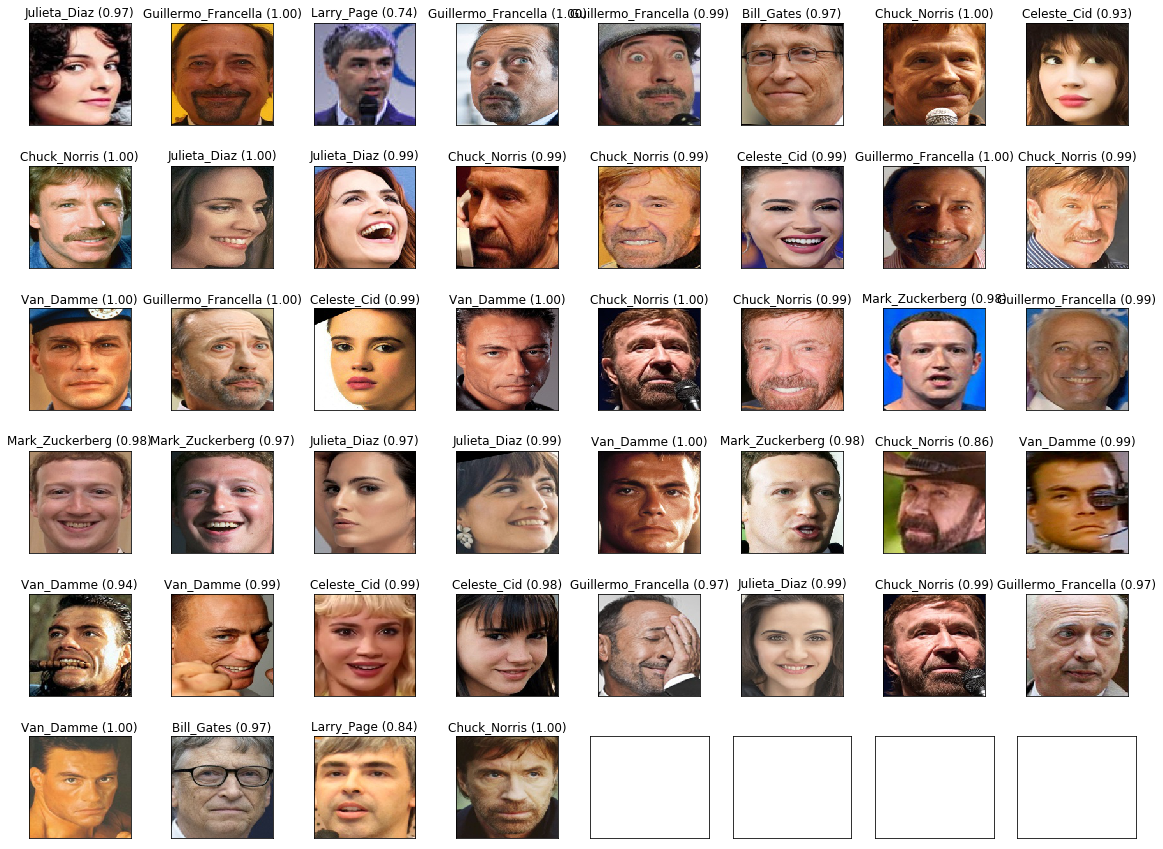

In [14]:
faces = len(embs)
img_per_row = min(faces, 8)
num_rows = math.ceil(faces/img_per_row)

fig, axes = plt.subplots(num_rows, img_per_row, figsize=(20, num_rows*2.5), sharex='col', sharey='row')
fig.subplots_adjust(hspace=0.4)#, wspace=0.1)

count = 0

for row in range(num_rows):
    for col in range(img_per_row):
        if count < faces:
            if pred[count] == y_test[count]:
                box = {'facecolor':'none', 'edgecolor':'none'}
            else:
                box = {'facecolor':'yellow', 'alpha':0.2}
            axes[row, col].set_title('{} ({:.2f})'.format(pred[count], proba[count]), bbox=box)
            axes[row, col].imshow(imread(x_test[count]))
            axes[row, col].set_xticks([])
            axes[row, col].set_yticks([])
        count += 1

plt.show()

### Augmented samples

This is a representation of how augmented images would look like on the training dataset.

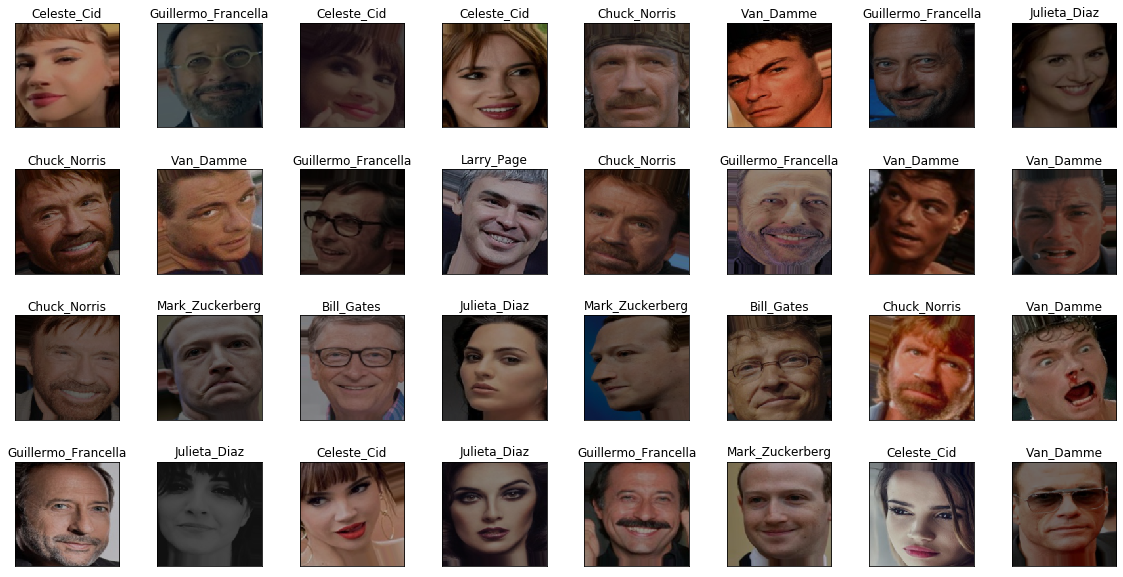

In [15]:
x_aug, y_aug = augmentation(load_images(x_train), y_train, 1)

faces = len(x_aug)
img_per_row = min(faces, 8)
num_rows = math.ceil(faces/img_per_row)

fig, axes = plt.subplots(num_rows, img_per_row, figsize=(20, num_rows*2.5), sharex='col', sharey='row')
fig.subplots_adjust(hspace=0.4)#, wspace=0.1)

count = 0

for row in range(num_rows):
    for col in range(img_per_row):
        if count < faces:
            box = {'facecolor':'none', 'edgecolor':'none'}
            axes[row, col].set_title('{}'.format(y_aug[count]), bbox=box)
            axes[row, col].imshow(x_aug[count].astype(np.uint8))
            axes[row, col].set_xticks([])
            axes[row, col].set_yticks([])
        count += 1

plt.show()

## Dataset

### Dataset distribution

In [16]:
l = np.array(list(Counter(dataset_y).keys()))
v = np.array(list(Counter(dataset_y).values()))

In [17]:
'Mean: {:.2f}, Std: {:.2f}, Min: {:.2f}, Max: {:.2f}, Total: {}'.format(v.mean(), v.std(),
                                                             v.min(), v.max(), v.sum())

'Mean: 12.00, Std: 5.89, Min: 4.00, Max: 21.00, Total: 96'

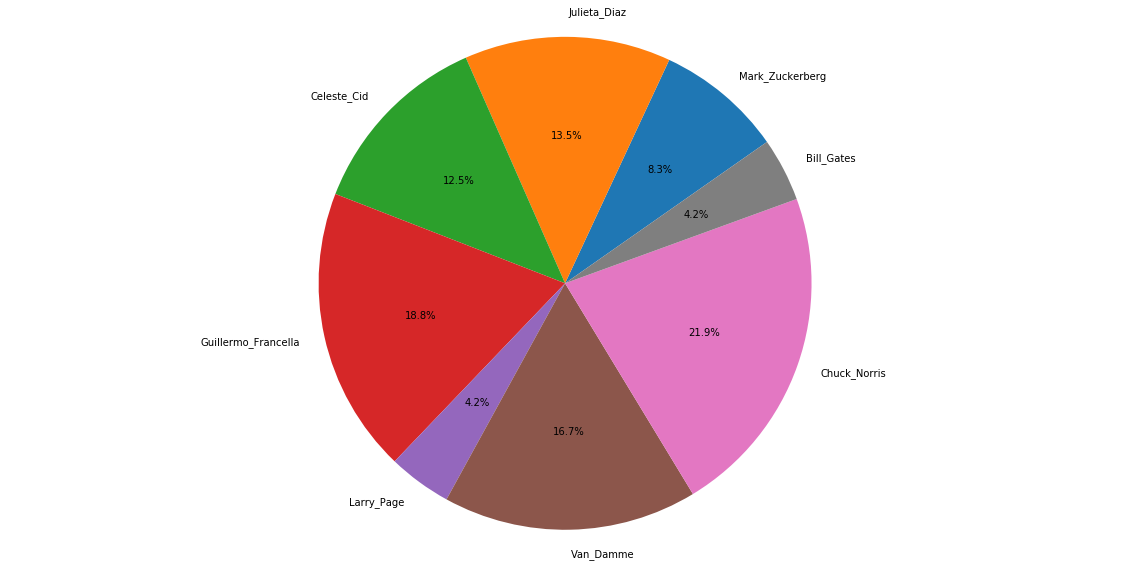

In [18]:
fig = plt.figure(figsize=(20,10))
plt.pie(v,labels=l, startangle=35, autopct='%1.1f%%')#, colors=plt.cm.Blues)
plt.axis('equal')
plt.show()

### Number of members on the Training set

In [19]:
Counter(y_train)

Counter({'Celeste_Cid': 7,
         'Van_Damme': 9,
         'Guillermo_Francella': 10,
         'Larry_Page': 2,
         'Chuck_Norris': 11,
         'Julieta_Diaz': 7,
         'Bill_Gates': 2,
         'Mark_Zuckerberg': 4})

### Number of members on the Test set

In [20]:
counter_y_test=Counter(y_test)
counter_y_test

Counter({'Julieta_Diaz': 6,
         'Guillermo_Francella': 8,
         'Larry_Page': 2,
         'Bill_Gates': 2,
         'Chuck_Norris': 10,
         'Celeste_Cid': 5,
         'Van_Damme': 7,
         'Mark_Zuckerberg': 4})

## Results

### Precision, Recall & F1-score

In [22]:
print(metrics.classification_report(lencoder.inverse_transform(y_true), lencoder.inverse_transform(y_pred)))

                     precision    recall  f1-score   support

         Bill_Gates       1.00      1.00      1.00         2
        Celeste_Cid       1.00      1.00      1.00         5
       Chuck_Norris       1.00      1.00      1.00        10
Guillermo_Francella       1.00      1.00      1.00         8
       Julieta_Diaz       1.00      1.00      1.00         6
         Larry_Page       1.00      1.00      1.00         2
    Mark_Zuckerberg       1.00      1.00      1.00         4
          Van_Damme       1.00      1.00      1.00         7

           accuracy                           1.00        44
          macro avg       1.00      1.00      1.00        44
       weighted avg       1.00      1.00      1.00        44



### General accuracy metrics

In [23]:
p = np.array(proba)
'Mean: {:.2f}, Std: {:.2f}, Min: {:.2f}, Max: {:.2f}, Total: {}'.format(p.mean(), p.std(), p.min(), p.max(), len(p))

'Mean: 0.97, Std: 0.05, Min: 0.74, Max: 1.00, Total: 44'

In [24]:
error_ids = []
pred_errors = []
pred_ok = []

for i, p in enumerate(y_pred):
    if p == y_true[i]:
        pred_ok.append(proba[i])
    else:
        error_ids.append(i)
        pred_errors.append(proba[i])

### Error accuracy metrics

In [25]:
pred_errors = np.array(pred_errors)
if len(pred_errors) > 0:
    'Mean: {:.2f}, Std: {:.2f}, Min: {:.2f}, Max: {:.2f}, Total: {}'.format(pred_errors.mean(), pred_errors.std(),
                                                                            pred_errors.min(), pred_errors.max(), len(pred_errors))

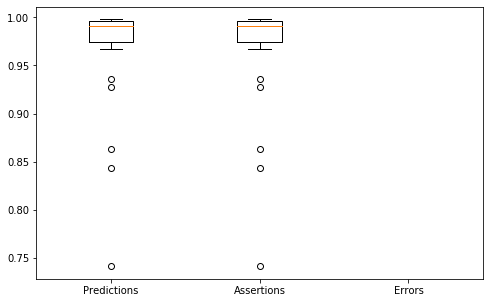

In [26]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.boxplot([proba, pred_ok, pred_errors], labels=['Predictions', 'Assertions', 'Errors'])

plt.show()

In [27]:
if len(pred_errors) > 0:
    err_threshold = pred_errors.mean() + pred_errors.std()
    err_threshold
else:
    err_threshold = 0

In [28]:
pred_errors[pred_errors > err_threshold]

array([], dtype=float64)

In [29]:
pred_errors.sort()
pred_errors

array([], dtype=float64)

### Successful accurancy metrics

In [30]:
pred_ok = np.array(pred_ok)
'Mean: {:.2f}, Std: {:.2f}, Min: {:.2f}, Max: {:.2f}, Total: {}'.format(pred_ok.mean(), pred_ok.std(),
                                                                        pred_ok.min(), pred_ok.max(), len(pred_ok))

'Mean: 0.97, Std: 0.05, Min: 0.74, Max: 1.00, Total: 44'

## Threshold

In [31]:
if len(pred_errors) > 0:
    threshold = max(pred_errors)
else:
    threshold = 0

threshold

0

In [32]:
discarded_ok = pred_ok[pred_ok <= threshold]
discarded_ok

array([], dtype=float64)

In [33]:
'Discarded samples: {}'.format(len(discarded_ok))

'Discarded samples: 0'

### Error rate (+threshold)

In [34]:
total_err = len(discarded_ok) + len(pred_errors)
total_samples = len(x_test)
'Error rate: {:.3f}'.format(total_err/total_samples*100)

'Error rate: 0.000'

In [35]:
total_ok = len(pred_ok[pred_ok > threshold])
'Model accuracy: {:.3f}'.format(total_ok/total_samples*100)

'Model accuracy: 100.000'

## Confusion Matrix

In [36]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Reference:
    https://github.com/javaidnabi31/Multi-class-with-imbalanced-dataset-classification/blob/master/20-news-group-classification.ipynb
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(aspect=40, shrink=0.90)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [37]:
cnf_matrix = metrics.confusion_matrix(y_true, y_pred)

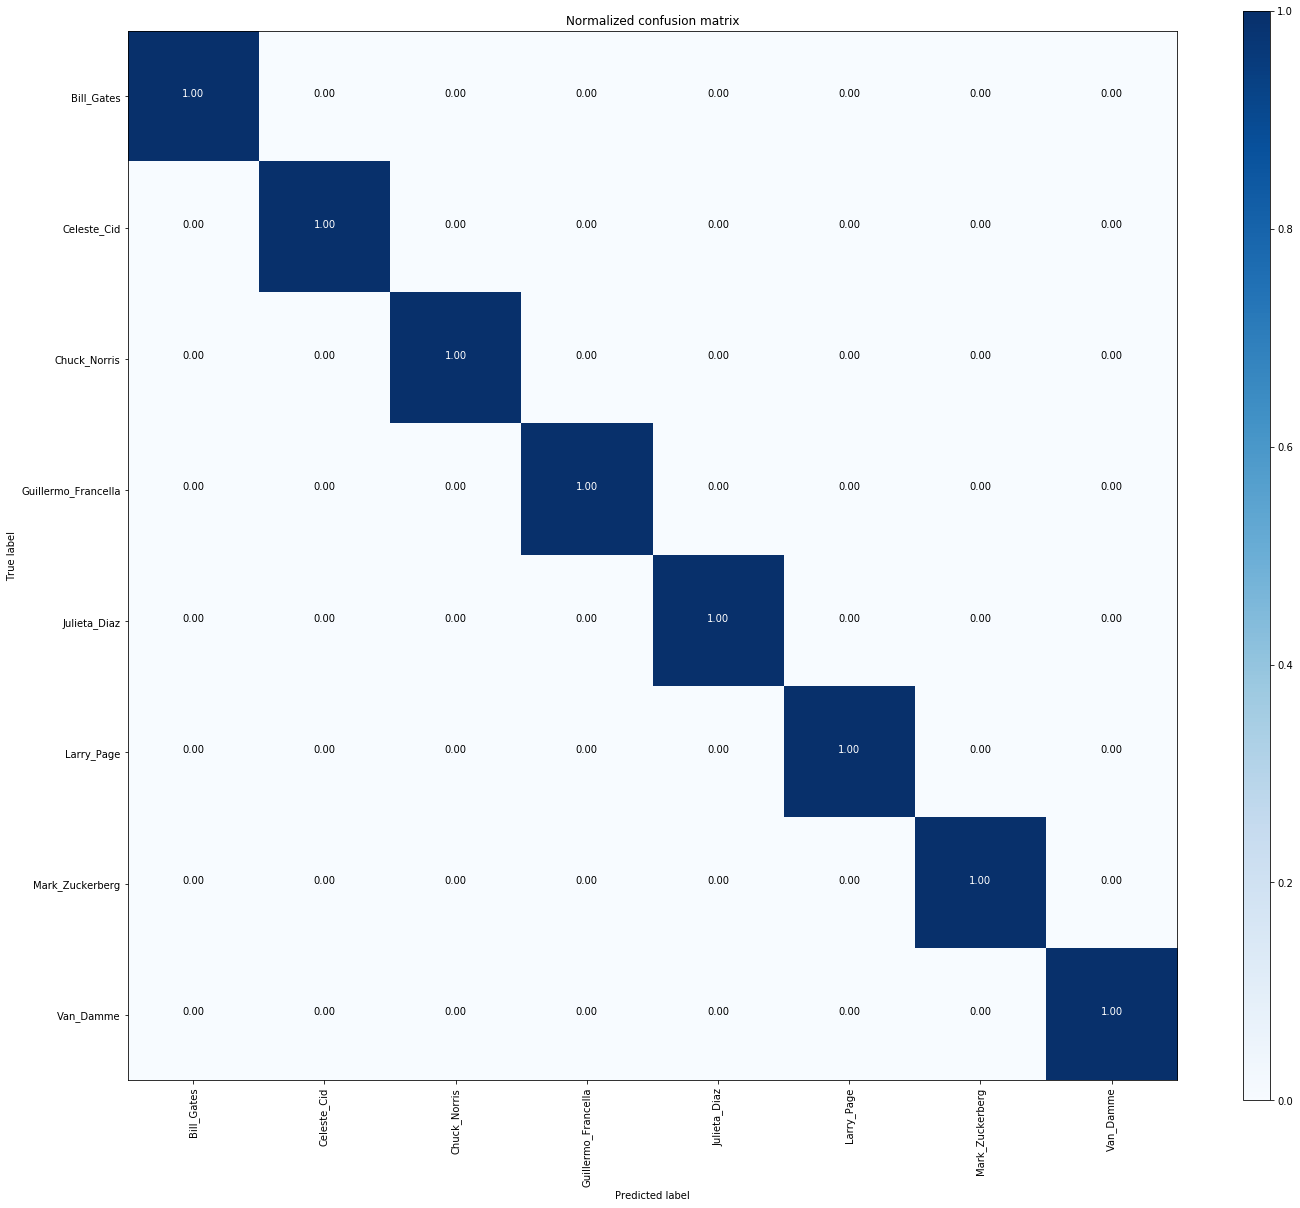

In [38]:
# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(20, 18, forward=True)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(lencoder.classes_), normalize=True,
                      title='Normalized confusion matrix')

## Persist trained model and labels

In [40]:
if persist_model:
    joblib.dump(clf, 'svm-model.sav')
    np.save('svm-labels.npy', lencoder.classes_)
    print('Model persisted as: svm-model.sav')